# ANN Classifier example in R

#### This is a simple tutorial for applying our ANN Classifier model on AML samples. 
- Our color list follows a simple methodology of going from immature cells to mature cells by lightening the cell-type color
- Our Model is located in the Model folder and it needs to be loaded before running the classification
- You can run the classification model by classification function.

** Enjoy it as much as we do! :)

In [10]:
library(Seurat)
library(Dict)
# library(ggplot2)
library(reticulate)



Attachement du package : 'reticulate'


L'objet suivant est masqu'e depuis 'package:Dict':

    dict




Color pallete we love:

In [11]:
color_mix <- Dict$new( 
#purple
'CD34+ HSC' = '#5A3AAB',
'CD34+ HSC-cycle' = '#7F38CF',
'CD34+ MultiLin' = '#BF7EED',

#Myeloid lineage  #blue
'Promyelocyte'= '#365D93',
'Myelocyte'= '#4D7BA8',
'Metamyelocyte/Band neutrophil'= '#6489BD',
'S100A+ preNeutrophil'= '#7AA7D2',
'S100A+ preNeutrophil (cycling)'= '#91C5E7',
    


'CD14+MHCIIlow monocyte'= '#2357F9',
'CD14+MHCIIhigh monocyte'= '#5E80FF',
'CD16+ monocyte'= '#1242e4',
'Macrophage'= '#0F35B0',
    
#  Dendretic cell = green     

'CDP'= '#009999',

'cDC1'= '#00E6E6',
'cDC2 (cycling)'= '#00B2B2',
'cDC2'= '#00CCCC',
'MoDC'= '#28b5f7',


'pre-pDC (myeloid origin)'= '#006633',
'pre-pDC (lymphoid origin)'= '#008066',
'pDC'= '#00FFFF',
 
 'Mast cell' = '#575f88' , 
    
# Ery #red
'CD34+ MEP' = '#78222E',
'Megakaryocyte progenitor'= '#8C2B3D',
'Megakaryocyte'= '#A03D51',
'Platelet' = '#ed9393',

'Early SOX4+ erythroblast'= '#B75268',
'Intermediate EPCAM+ erythroblast'= '#C9617A',
'Late hemoglobin+ erythroblast'= '#DA748C',
# 'Fetal HBG+ erythrocyte'= '#E78E9C',
'Erythrocyte'= '#DC143C',    

# Lymphocyte B
'CD34+ LMPP' = "#C83DE0",
'CD34+ CLP' = "#CF5BE3",
# 'CLP'= '#C71585',
# 'ILC' = '#D37EED',        
'preB cell (cycling)'= '#D582F0', 
'preB cell'='#D986E7', 
'proB cell (cycling)'='#E091E1', 
'proB cell'='#E69DDC', 
'Naive B cell'= '#EEA9D6',
'Memory B cell'='#F3B6D1', 
'Plasma Cell' = '#C71585',

'ILC' = '#faa997',   #
# Lymphocyte T/NK
'T/NK cell (cycling)'= '#FF5733',
'Naive CD8 T cell'= '#FF7F50',
'Naive CD4 T cell'= '#FFA07A',
'Effector/Memory CD4 T cell'= '#FFC2A7',
'Treg'= '#FFD1A7',
'GZMK+ CD8 T cell'= '#FEDCB3',
'GZMB+ CD8 T cell'= '#FEE0C2',
'MAIT'= '#FEE5D0',
'Gamma-delta T cell'= '#FEEBDB',
'IFN-activated T cell'= '#FEEDE6',
'CD16+ NK'= '#FEC9A8',
'Tissue-resident NK cell'= '#FED6BB',
'CD56+ NK'= '#FEE2CE',


'Stromal' = "#ffd000" 

)

color_palette <- as.list(color_mix$values)
names(color_palette) <- color_mix$keys

## Classification funcation

In [5]:
# load features
modeldir='Model/'
features <- read.csv(paste0(modeldir,"ANNClassifier_features.txt"),header=F)
features = as.vector(features)$V1
# load the model from disk
model = reticulate::py_load_object(paste0(modeldir,'ANNClassifier.sav'))

In [6]:
classification <- function(adata,features_all,model_all_cell_types){
        
    #adata was filtering for unexpressed genes. We add genes that are
    #in the model but not in adata. We add them as zero in a new adata
    absent_features <- setdiff(features_all,rownames(adata))
    temp <- as.data.frame(matrix(0, ncol = length(absent_features), nrow = length(colnames(adata))),row.names=colnames(adata))
    colnames(temp) <- absent_features
    final_df <- cbind(t(as.data.frame(adata@assays$RNA@data)),temp)
    head(final_df)       
    
    # annotate cell types
    df_test_all_ct <- final_df[, features_all]
    head(df_test_all_ct)
    pred_cell_types = model_all_cell_types$predict(df_test_all_ct)

    adata@meta.data$'New_annotations' = pred_cell_types
    return (adata)
}


## Read in your sample here

In [12]:
load(file = 'test_data/GalenFullNormalized_test.RDat', verbose=T)
GalenFull

Loading objects:
  GalenFull


An object of class Seurat 
27899 features across 15685 samples within 1 assay 
Active assay: RNA (27899 features, 0 variable features)
 2 dimensional reductions calculated: umap, pca

- <b> Normalize your data if its not already using the following method:

In [ ]:
## Normalization in Seurat
# GalenFull <- NormalizeData(GalenFull, margin = 1,normalization.method = "LogNormalize", scale.factor = 10000)

###  Running the Classification function 

In [8]:
GalenFull <- classification(GalenFull,features,model)

<b>- UMAP of result

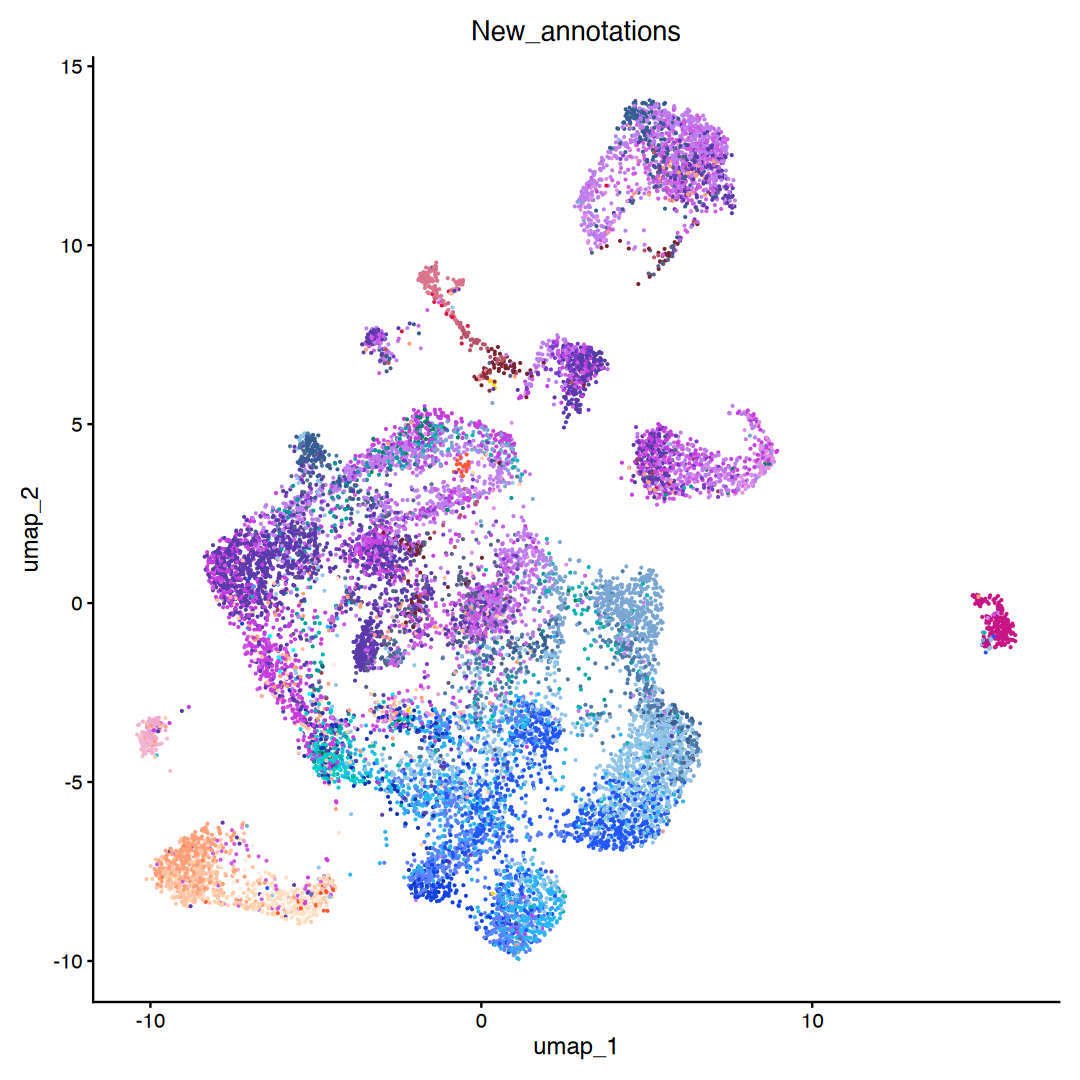

In [9]:
GalenFull@meta.data$'New_annotations' <- factor(GalenFull@meta.data$'New_annotations', levels=color_mix$keys)
options(repr.plot.height =9, repr.plot.width=9)
DimPlot(GalenFull, reduction = 'umap', group.by = 'New_annotations', cols = color_palette, pt.size = 0.1,  label =F,na.value = 'lightgrey',repel = TRUE, raster=FALSE)+ NoLegend() #

<b> You are done! :D 